# Chapter 16: Multivariate statistics

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, t, binom, scoreatpercentile, pearsonr
from scipy.spatial.distance import cdist
import pingouin as pg
import matplotlib
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import KFold
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from scipy.cluster import hierarchy
from sklearn.decomposition import PCA

%matplotlib inline 
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
pandas2ri.activate()
from rpy2.robjects.conversion import localconverter
# import NHANES package
base = importr('NHANES')
%load_ext rpy2.ipython

with localconverter(ro.default_converter + pandas2ri.converter):
  NHANES = ro.conversion.rpy2py(ro.r['NHANES'])

 
NHANES = NHANES.drop_duplicates(subset='ID')
NHANES_adult = NHANES.dropna(subset=['Weight']).query('Age > 17 and BPSysAve > 0')

rng = np.random.default_rng(1234567)

## Multivariate data setup

In [2]:
behavdata = pd.read_csv('https://raw.githubusercontent.com/statsthinking21/statsthinking21-figures-data/main/Eisenberg/meaningful_variables.csv')
behavdata.set_index('subcode', inplace=True)
demoghealthdata = pd.read_csv('https://raw.githubusercontent.com/statsthinking21/statsthinking21-figures-data/main/Eisenberg/demographic_health.csv')
demoghealthdata.set_index('subcode', inplace=True)
sexdict = {1:'Female', 0:'Male'}
demoghealthdata['Sex'] = [sexdict[i] for i in demoghealthdata['Sex']]
alldata = demoghealthdata.join(behavdata, how='inner')

rename_dict = {
    'upps_impulsivity_survey': 'UPPS',
    'sensation_seeking_survey': 'SSS',
    'dickman_survey': 'Dickman', 
    'bis11_survey': 'BIS11',
    'spatial_span': 'spatial',
    'digit_span': 'digit',
    'adaptive_n_back': 'nback',
    'dospert_rt_survey': 'dospert',
    'motor_selective_stop_signal.SSRT': 'SSRT_motorsel',
    'stim_selective_stop_signal.SSRT': 'SSRT_stimsel',
    'stop_signal.SSRT_low': 'SSRT_low',
    'stop_signal.SSRT_high': 'SSRT_high'
}

impulsivity_vars = []
for column in alldata.columns:
    for k, v in rename_dict.items():
        if k in column:
            alldata.rename(columns={column: column.replace(k, v)}, inplace=True)
            impulsivity_vars.append(column.replace(k, v))


impulsivity_data = alldata[impulsivity_vars].dropna()


ssrtdata = alldata[[i for i in alldata.columns if 'SSRT_' in i and 'proactive' not in i]].dropna()

uppsdata = alldata[[i for i in alldata.columns if 'UPPS.' in i]].dropna()
for column in uppsdata.columns:
    uppsdata.rename(columns={column: column.replace('UPPS.','')}, inplace=True)
    
impdata = ssrtdata.join(uppsdata, how='inner').dropna()

for column in impdata.columns:
    impdata[column] = scale(impdata[column].values)

var_dict = {'SSRT_motor': 'SSRT_motorsel',
            'SSRT_stim': 'SSRT_stimsel',
            'UPPS_pers': 'lack_of_perseverance',
            'UPPS_premed': 'lack_of_premeditation',
            'UPPS_negurg': 'negative_urgency',
            'UPPS_posurg': 'positive_urgency',
            'UPPS_senseek': 'sensation_seeking'
           }
impdata.rename(columns=var_dict, inplace=True)

## Figure 16.1

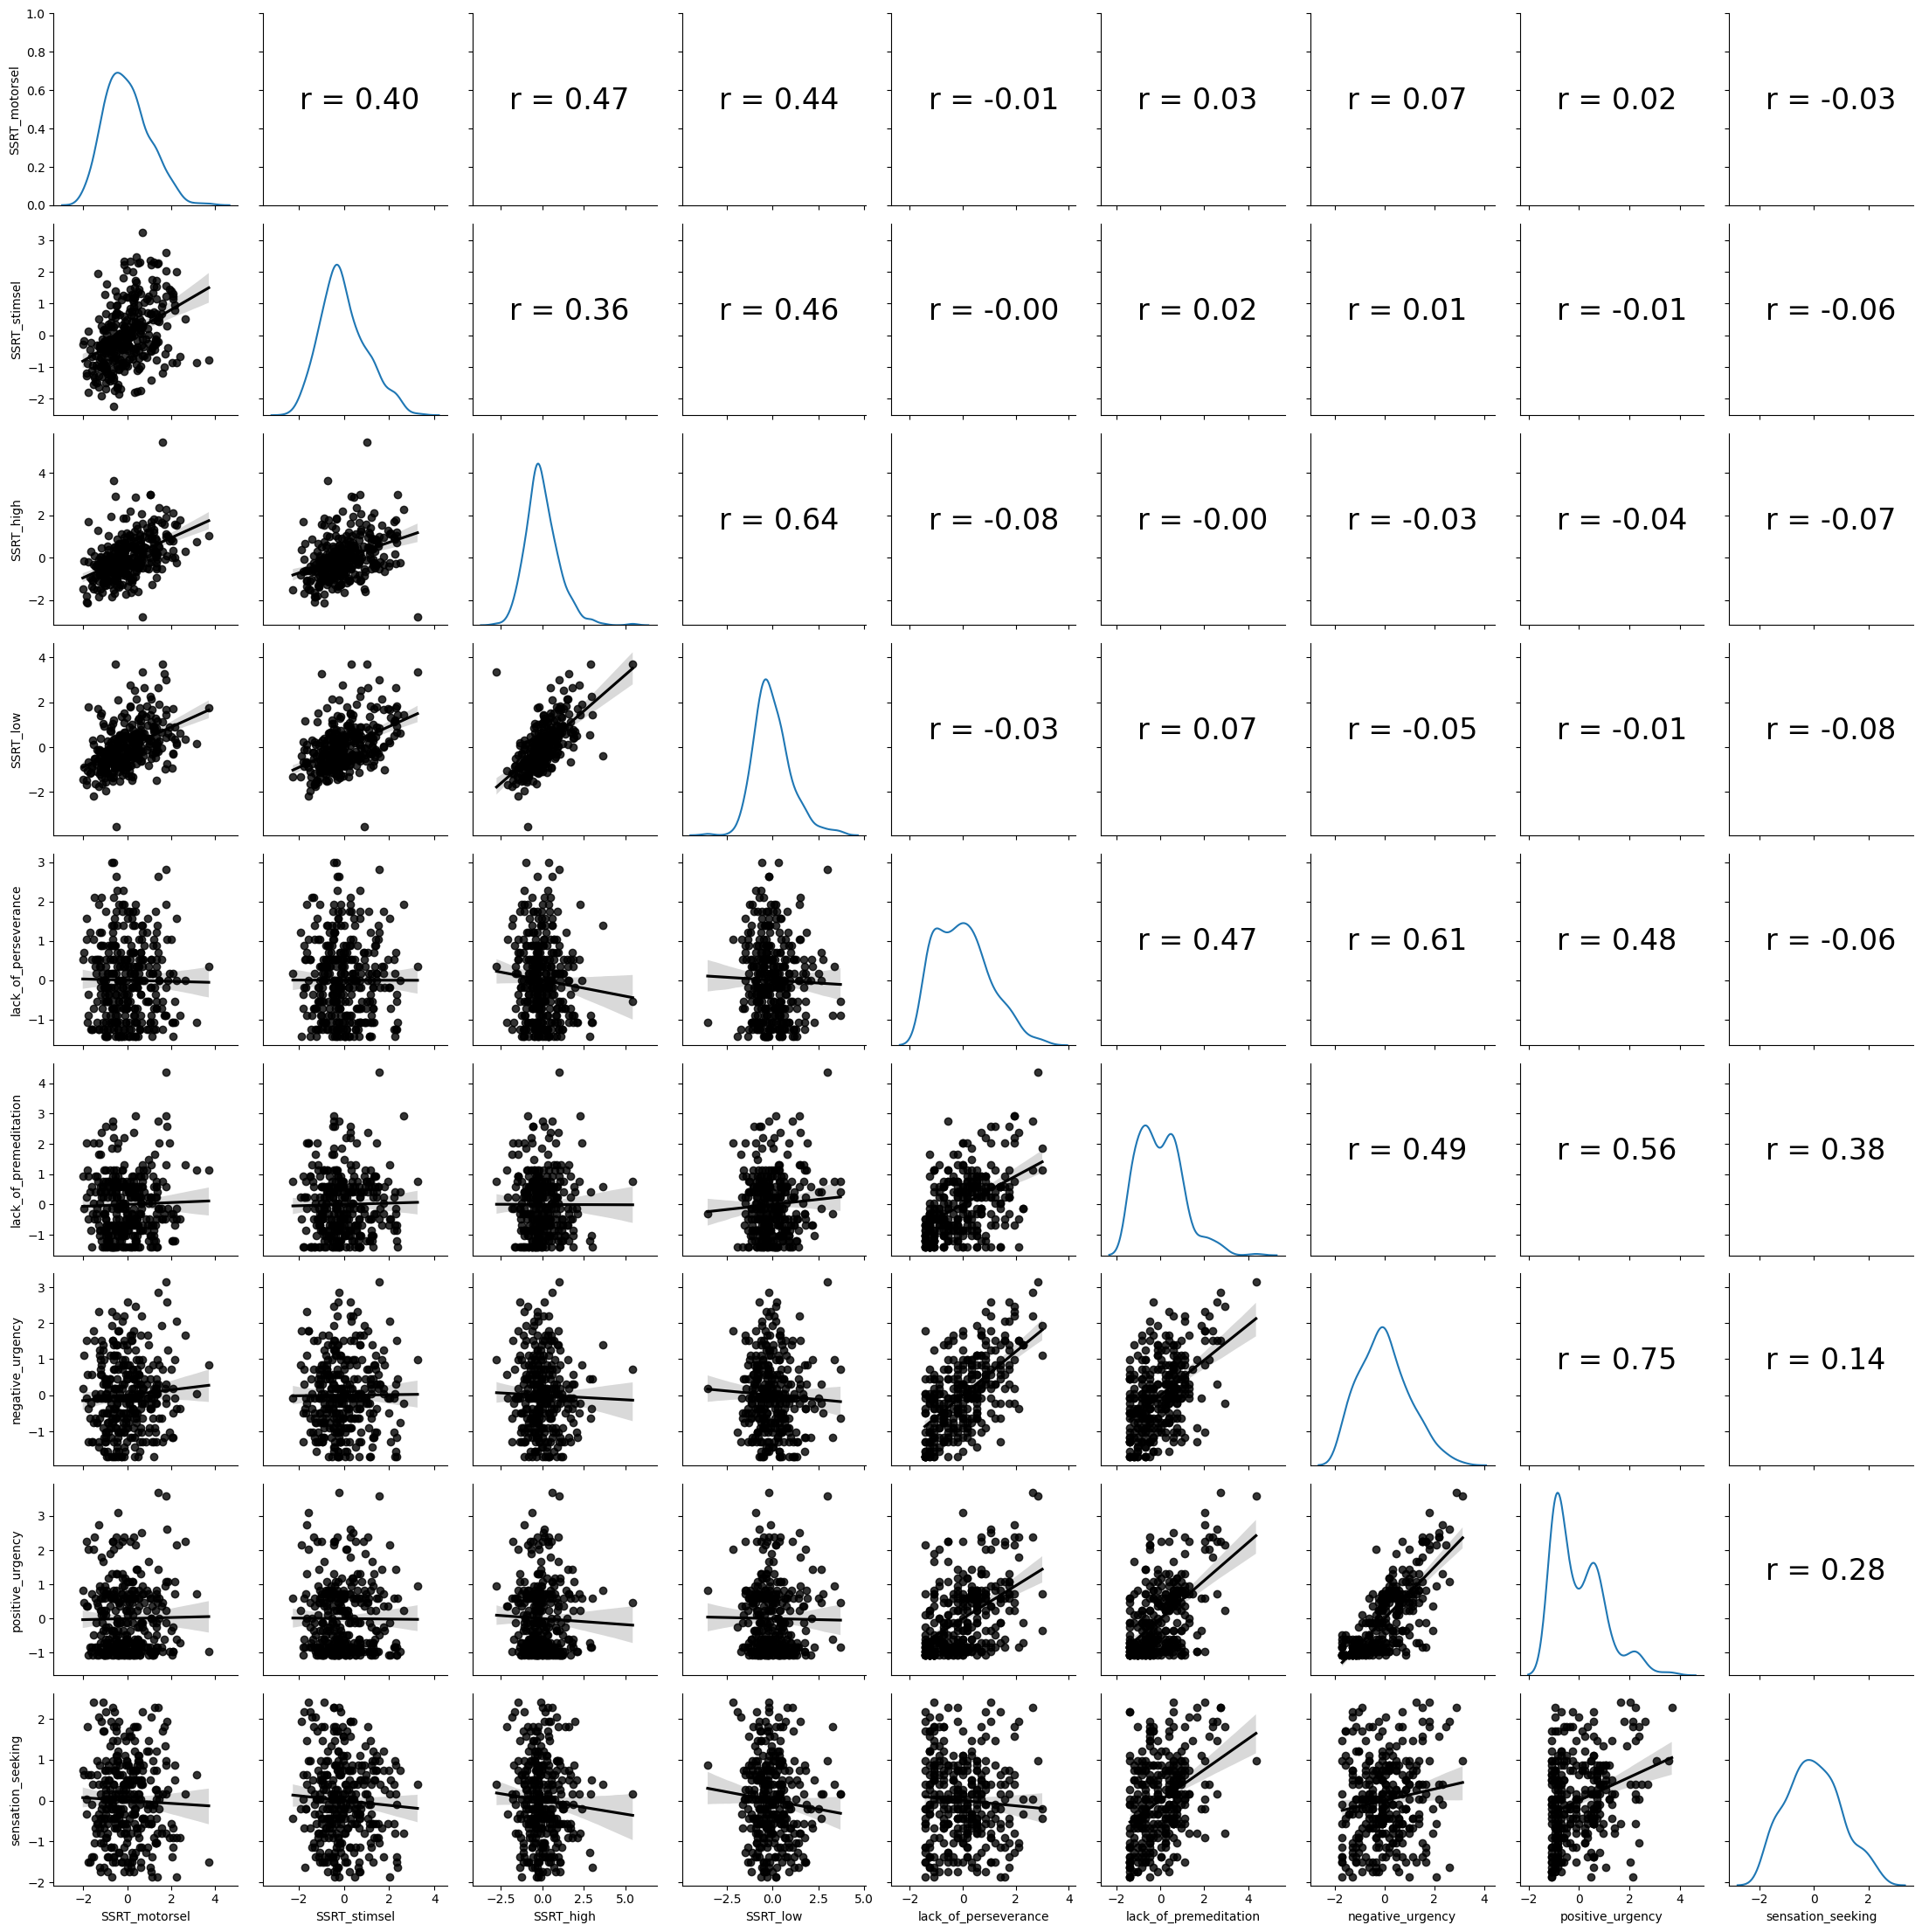

In [3]:
g = sns.PairGrid(impdata)

def corrfunc(x, y, hue=None, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    r, _ = pearsonr(x, y)
    ax = ax or plt.gca()
    ax.annotate(f'r = {r:.2f}', xy=(.2, .5), size=24, xycoords=ax.transAxes)

g.map_upper(corrfunc)
g.map_lower(sns.regplot, color='black')
g.map_diag(sns.kdeplot, legend=False)
plt.show()

## Figure 16.2

<AxesSubplot: >

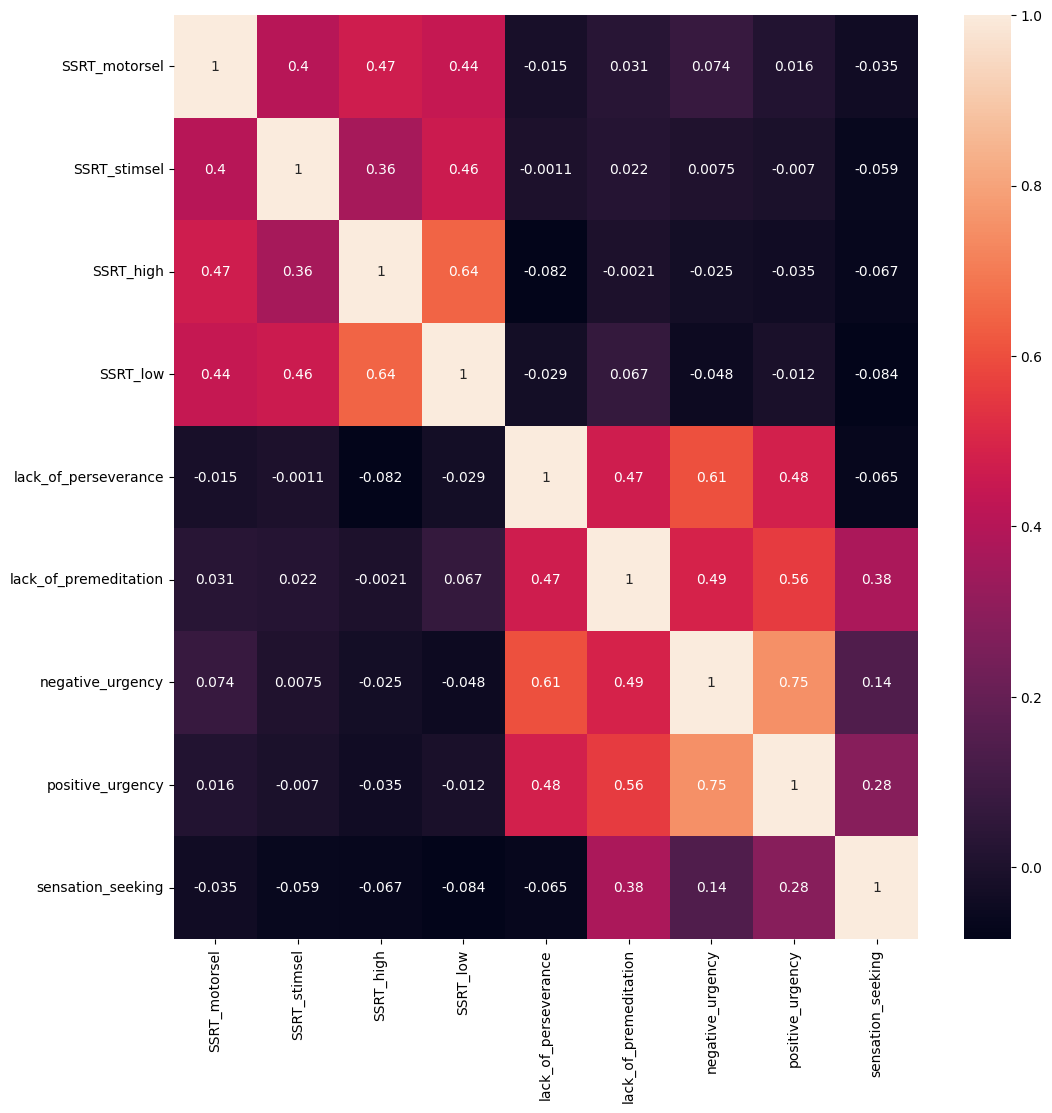

In [4]:
plt.figure(figsize=(12,12))
cc = impdata.corr()

sns.heatmap(cc, annot=True)


## Figure 16.3

<AxesSubplot: >

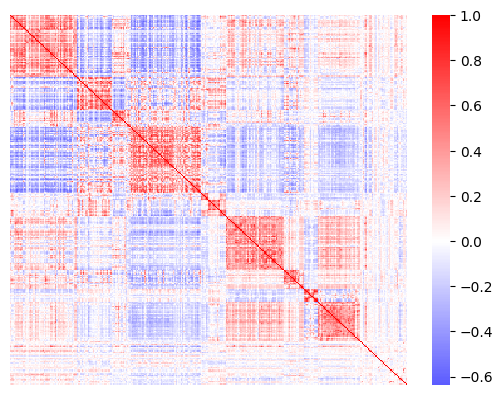

In [5]:
ccmtx = pd.read_csv('https://raw.githubusercontent.com/statsthinking21/statsthinking21-figures-data/main/myconnectome/ccmtx_sorted.txt', header=None, delimiter=' ').values
parcel_data = pd.read_csv('https://raw.githubusercontent.com/statsthinking21/statsthinking21-figures-data/main/myconnectome/parcel_data.txt',  header=None, delimiter='\t')
parcel_data.columns = ['parcelnum', 'hemis', 'X', 'Y', 'Z', 'lobe', 'region', 'network', 'yeo7network', 'yeo17network']
parcel_data = parcel_data.sort_values(by=['hemis', 'yeo7network'])
parcel_data['netdiff'] = False
parcel_data.iloc[1:, -1] =  parcel_data.yeo7network[1:].values != parcel_data.yeo7network[:-1].values

hemis_to_use = 'L'

tmp = ccmtx[parcel_data.hemis == hemis_to_use, :]
ccmtx_hemis = tmp[:, parcel_data.hemis == hemis_to_use]
hemis_parcel_data = parcel_data.query('hemis == "{hemis_to_use}"')

sns.heatmap(ccmtx_hemis, cmap='bwr', center=0,
           yticklabels=False, xticklabels=False)

## Figure 16.4

(0.0, 4.0)

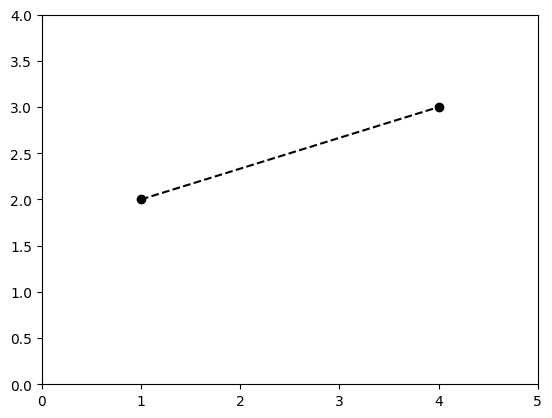

In [6]:
plt.plot([1, 4], [2, 3], 'k--o')
plt.xlim((0, 5))
plt.ylim((0, 4))


## Figure 16.5

Completed after 11 iterations


<AxesSubplot: xlabel='longitude', ylabel='latitude'>

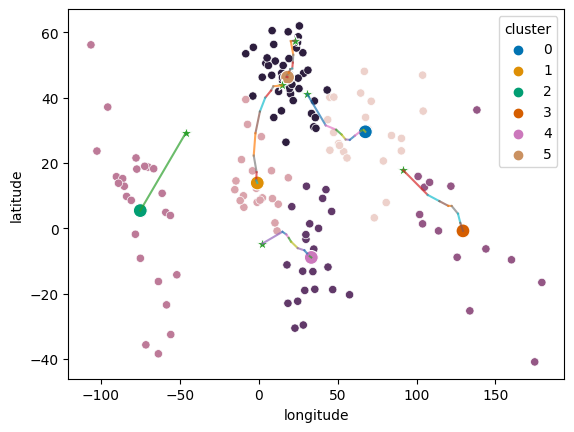

In [7]:
## Figure differs slightly from book due to differences in random sampling

countries = pd.read_csv('https://raw.githubusercontent.com/statsthinking21/statsthinking21-figures-data/main/countries/country_data.csv').query('Population2020 > 500000')
latlong = countries[['latitude', 'longitude']]

# based on https://stanford.edu/~cpiech/cs221/handouts/kmeans.html
# need to clarify license!
# and https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html
# (Code under MIT license)

k = 6
centroids = latlong.sample(k, random_state=rng)

iterations = 0
oldCentroids = None
MAX_ITERATIONS = 100

def shouldStop(oldCentroids, centroids, iterations):
    if iterations > MAX_ITERATIONS:
        return(True)

    if oldCentroids is None:
        return(False)

    return((centroids.values == oldCentroids.values).all())


def getLabels(dataSet, centroids):
    d = cdist(dataSet, centroids)

    # For each element in the dataset, chose the closest centroid.
    # Make that centroid the element's label.
    return(d.argmin(axis=1))


def getCentroids(dataSet, labels, k):
    # Each centroid is the geometric mean of the points that
    # have that centroid's label. Important: If a centroid is empty (no points have
    # that centroid's label) you should randomly re-initialize it.
    newCentroids = []
    for i in range(k):
      labeldata = dataSet.loc[labels==i, :]
      newCentroids.append(labeldata.mean(axis=0))

    return(pd.DataFrame(newCentroids))

all_centroids = None


while not shouldStop(oldCentroids, centroids, iterations):
    # Save old centroids for convergence test. Book keeping.
    oldCentroids = centroids
    iterations = iterations + 1
    # Assign labels to each datapoint based on centroids
    labels = getLabels(latlong, centroids)

    # Assign centroids based on datapoint labels
    centroids = getCentroids(latlong, labels, k)
    centroids_df = centroids.copy()
    centroids_df['iteration'] = iterations
    centroids_df['cluster'] = list(range(centroids.shape[0]))
    if all_centroids is None:
        all_centroids = centroids_df
    else:
        all_centroids = pd.concat((all_centroids, centroids_df))

print(f'Completed after {iterations} iterations')
countries['cluster'] = labels

sns.scatterplot(data=countries, x='longitude', y='latitude', hue='cluster', legend=False)
sns.scatterplot(data=centroids_df, x='longitude', y='latitude', hue='cluster', s=100, palette='colorblind')

for i in range(1, iterations):
    for j in range(k):
        iter_df = all_centroids.query(f'iteration == {i + 1} and cluster=={j}')
        prev_df = all_centroids.query(f'iteration == {i} and cluster=={j}')
        plt.plot([iter_df.longitude, prev_df.longitude], [iter_df.latitude, prev_df.latitude], alpha=0.7)

sns.scatterplot(data=all_centroids.query('iteration == 1'), x='longitude', y='latitude', 
                legend=False, marker='*', s=80)

## Table 16.1

Comparison of k-means clustering result to actual continents.


In [9]:
pd.crosstab(countries.Continent, countries.cluster).T

Continent,AF,AS,EU,OC,SA
cluster,,,,,
0,0,22,0,0,0
1,19,0,1,0,0
2,0,0,0,0,11
3,0,8,0,6,0
4,22,0,0,0,0
5,2,5,35,0,0


## Figure 16.6

scikit-learn uses a non-random initialization ("kmeans++") that results in greater stability of the resulting clusters compared to the random initialization in R's kmeans function.

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:8

<Axes: >

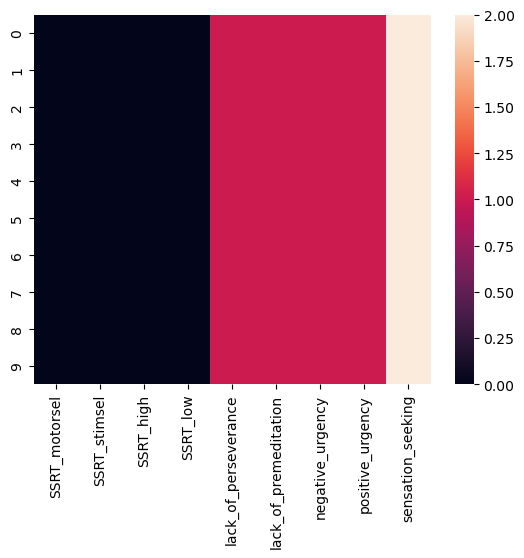

In [9]:
cluster_results = []

rstate = np.random.RandomState(1234567)

for i in range(10):
    kmeans = KMeans(n_clusters=3, random_state=rstate).fit(impdata.T)
    cluster_results.append(kmeans.labels_)
    if i > 0 and adjusted_rand_score(cluster_results[i], cluster_results[i - 1]) == 1:
        cluster_results[i] = cluster_results[i - 1]
    

results_df = pd.DataFrame(cluster_results, columns=impdata.columns)


sns.heatmap(results_df)

## Figure 16.7

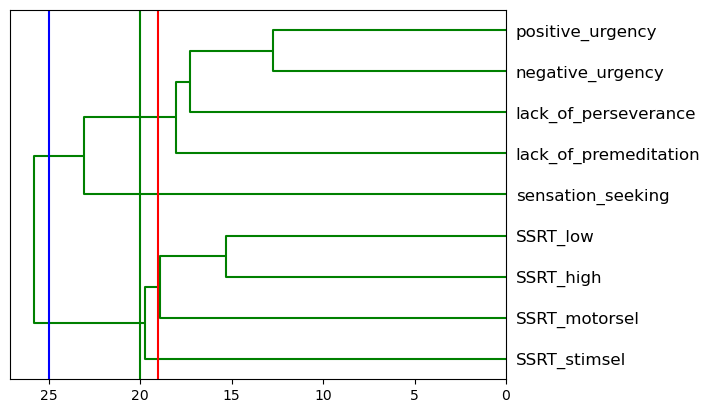

In [10]:

# Plot the hierarchical clustering as a dendrogram.
temp = hierarchy.linkage(impdata.T, 'average')

dn = hierarchy.dendrogram(
    temp, above_threshold_color="green", color_threshold=.7, 
    labels=impdata.columns, orientation='left')

cutoffs = [25, 20, 19]
colors = ['blue', 'green', 'red']

for i, c in enumerate(cutoffs):
    plt.plot([c, c], [0, 100], color=colors[i])


## Figure 16.8

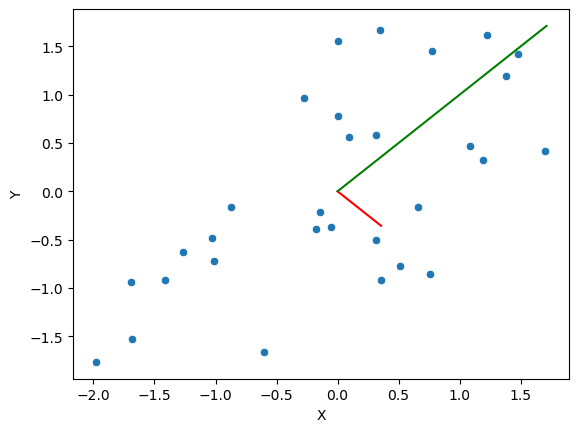

In [11]:
N = 30                           #setting my sample size
mu = [0, 0]                      #setting the means
c1 = .7

sigma = np.array([[1, c1], [c1, 1]])  #setting the covariance matrix values. The "2,2" part at the tail end defines the number of rows and columns in the matrix


sim_df = pd.DataFrame(scale(rng.multivariate_normal(mu, sigma, size=N)),
                      columns=['Y', 'X'])

cov_eig_values, cov_eig_vectors = np.linalg.eigh(sim_df.cov())
cov_eig_slopes = np.array([
    cov_eig_vectors[0, 0] / cov_eig_vectors[1, 0],
    cov_eig_vectors[0, 1] / cov_eig_vectors[1, 1]])

sns.scatterplot(data=sim_df, x='X', y='Y')
plt.plot([0, cov_eig_values[0]], [0, cov_eig_slopes[0] * cov_eig_values[0]], color='red')
plt.plot([0, cov_eig_values[1]], [0, cov_eig_slopes[1] * cov_eig_values[1]], color='green')




## Figure 16.9

[0.60018896 0.16768757 0.14725293 0.08487054]


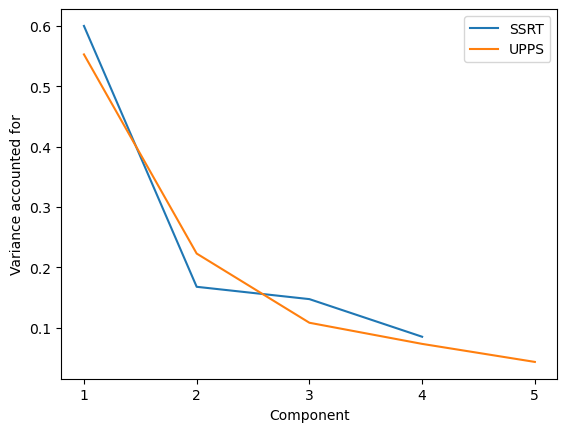

In [12]:
ssrtdata = impdata[[i for i in impdata.columns if 'SSRT' in i]]

pca_ssrt = PCA()
pca_ssrt.fit(ssrtdata)
pca_ssrt_varacct = pca_ssrt.explained_variance_ratio_
print(pca_ssrt_varacct)

uppsdata = impdata[[i for i in impdata.columns if 'SSRT' not in i]]

pca_upps = PCA()
pca_upps.fit(uppsdata)
pca_upps_varacct = pca_upps.explained_variance_ratio_

sns.lineplot(x=np.arange(1, 5, dtype='int'), y=pca_ssrt_varacct, label='SSRT')
sns.lineplot(x=np.arange(1, 6, dtype='int'), y=pca_upps_varacct, label='UPPS')

plt.ylabel('Variance accounted for')
plt.xlabel('Component')

_ = plt.xticks(np.arange(1, 6, dtype='int'))

## Correlation test for PCA components

In [13]:
ssrt_pred = pca_ssrt.transform(ssrtdata)[:, 0]
upps_pred = pca_upps.transform(uppsdata)[:, 0]

pg.corr(ssrt_pred, upps_pred)

,n,r,CI95%,p-val,BF10,power
pearson,329,-0.014819,"[-0.12, 0.09]",0.788861,0.072,0.058214


##  Figure 16.10

Text(0.5, 0, 'Component')

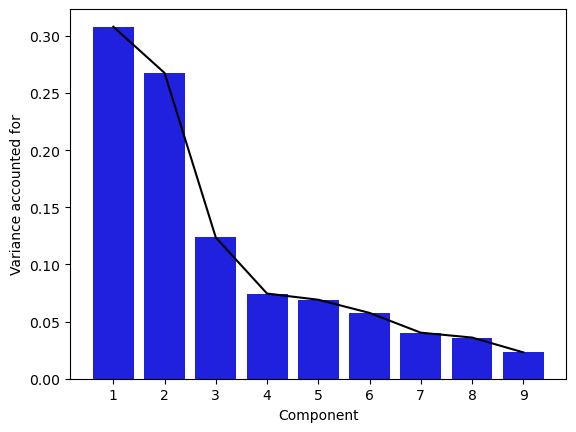

In [14]:
imp_pca = PCA()
imp_pca.fit(impdata)

sns.barplot(x=np.arange(1, 10), y=imp_pca.explained_variance_ratio_, color='blue')
sns.lineplot(x=np.arange(0, 9), y=imp_pca.explained_variance_ratio_, color='black', )

plt.ylabel('Variance accounted for')
plt.xlabel('Component')


## Figure 16.11

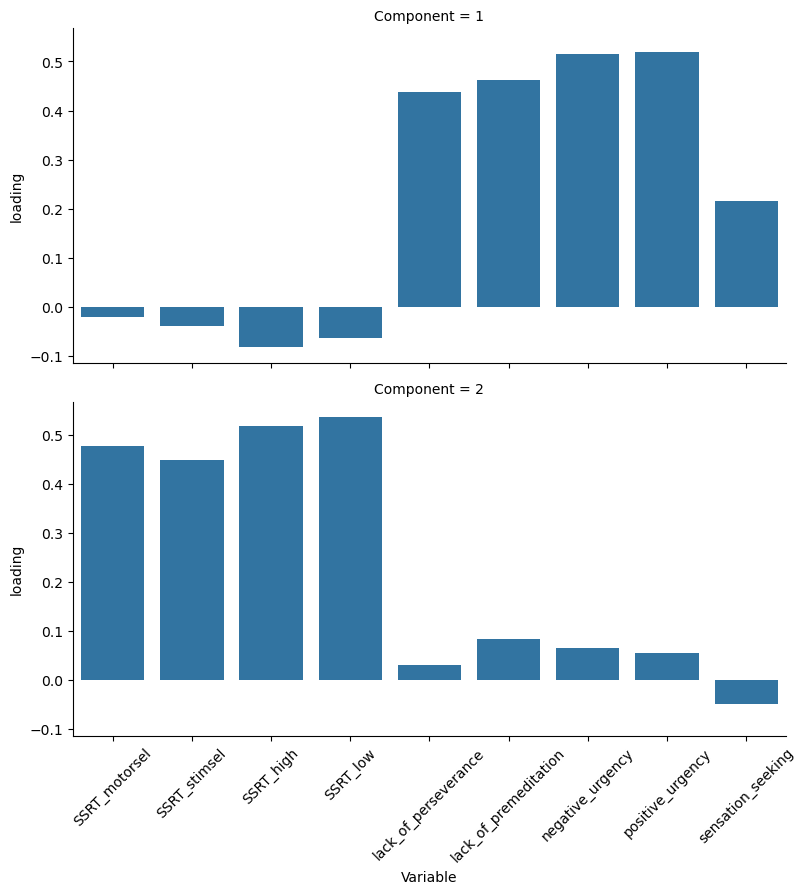

In [15]:
loading_df = pd.DataFrame(imp_pca.components_, columns=impdata.columns)
loading_df['Component'] = np.arange(1, 10)
loading_df = loading_df.query('Component < 3')
loading_df_long = pd.melt(loading_df, id_vars=['Component'], var_name='Variable', value_name='loading')

g = sns.FacetGrid(loading_df_long, row="Component", height=4, aspect=2)
g.map_dataframe(sns.barplot, x="Variable", y="loading")
plt.xticks(rotation = 45) # Rotates X-Axis Ticks by 45-degrees
g.add_legend()

## Figure 16.12

<Axes: >

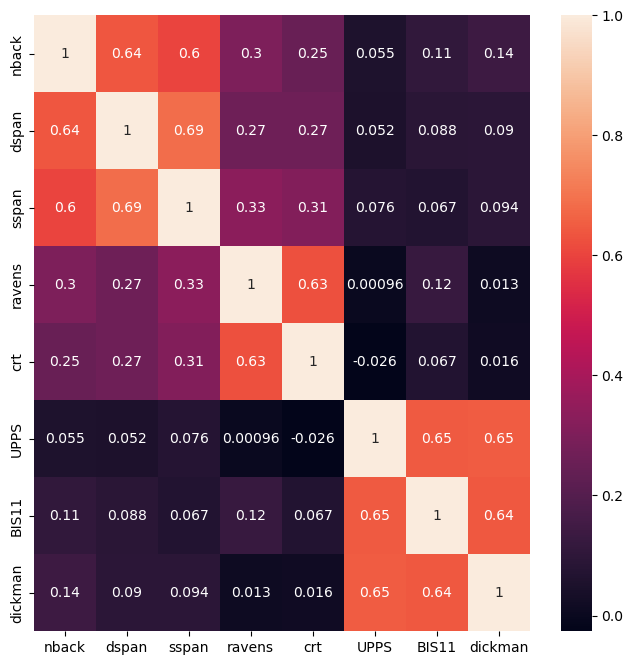

In [16]:
N = 200    # sample size
mu = [0] * 3  # means
c1 = .5 # correlation b/w WM and FR

sigma = np.array([[1, c1, 0], [c1, 1, 0], [0, 0, 1]])

latent_df = pd.DataFrame(scale(rng.multivariate_normal(mu, sigma, size=N)),
                         columns=['WM', 'FR', 'IMP'])

tasknames = ['nback', 'dspan', 'sspan', 'ravens', 'crt', 'UPPS', 'BIS11', 'dickman']
ntasks = len(tasknames)
weights = np.zeros((3, ntasks))
weights[0, 0:3] = 1
weights[1, 3:5] = 1
weights[2, 5:8] = 1

noise_sd = .6
observed_df = pd.DataFrame(
    latent_df.values.dot(weights) + rng.multivariate_normal(np.zeros(ntasks), np.eye(ntasks) * noise_sd, size=N),
    columns=tasknames)

cormtx = observed_df.corr()

plt.figure(figsize=(8,8))
sns.heatmap(cormtx, annot=True)


## Factor analysis output

eta1 =~ dspan + sspan + nback
eta2 =~ UPPS + dickman + BIS11
eta3 =~ ravens + crt



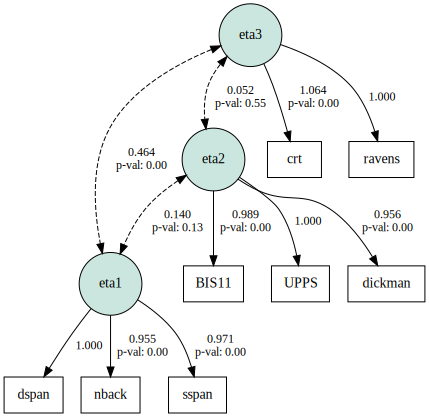

In [17]:
import semopy

fa = semopy.efa.explore_cfa_model(observed_df)
print(fa)

m = semopy.Model(fa)
m.fit(observed_df)

semopy.semplot(m, "pd.png", plot_covs=True)

The Psych package in R provides more powerful factor analysis tools, so we will use it for the foregoing analyses.

In [20]:
%%R -i observed_df 

library(psych)
fa_result <- fa(observed_df, nfactors = 3)
summary(fa_result)

R[write to console]: Loading required namespace: GPArotation




Factor analysis with Call: fa(r = observed_df, nfactors = 3)

Test of the hypothesis that 3 factors are sufficient.
The degrees of freedom for the model is 7  and the objective function was  0.02 
The number of observations was  200  with Chi Square =  4.09  with prob <  0.77 

The root mean square of the residuals (RMSA) is  0.01 
The df corrected root mean square of the residuals is  0.02 

Tucker Lewis Index of factoring reliability =  1.02
RMSEA index =  0  and the 10 % confidence intervals are  0 0.06
BIC =  -33
 With factor correlations of 
     MR1  MR2  MR3
MR1 1.00 0.12 0.38
MR2 0.12 1.00 0.05
MR3 0.38 0.05 1.00


## Figure 16.13

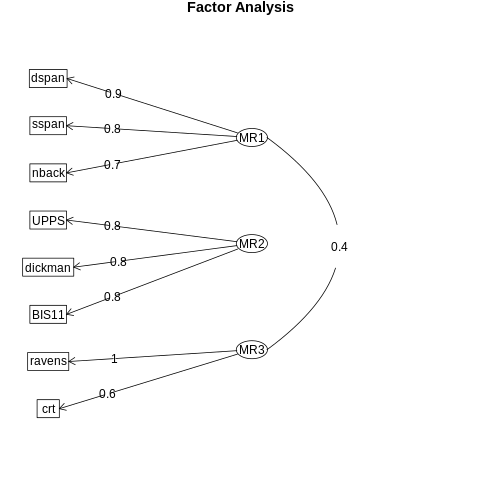

In [21]:
%%R

fa.diagram(fa_result)

## Figure 16.14

In [22]:
%%R -o BIC_results

library(ggplot2)
BIC_results = data.frame(nfactors=seq(1, 4), SABIC=NA)

for (i in 1:nrow(BIC_results)){
  BIC_results$SABIC[i] = fa(observed_df, nfactors=BIC_results$nfactors[i])$SABIC
}



R[write to console]: 
Attaching package: ‘ggplot2’


R[write to console]: The following objects are masked from ‘package:psych’:

    %+%, alpha




<Axes: xlabel='nfactors', ylabel='SABIC'>

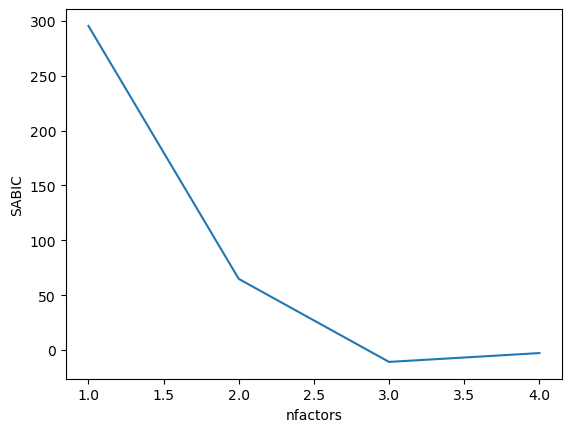

In [23]:
sns.lineplot(data=BIC_results, x='nfactors', y='SABIC')

## Figure 16.15

In [24]:
imp_efa_df = behavdata[[
    'adaptive_n_back.mean_load',
    'bis11_survey.Nonplanning',
    'cognitive_reflection_survey.correct_proportion',
    'dickman_survey.dysfunctional',
    'digit_span.reverse_span',
    'ravens.score',
    'spatial_span.reverse_span',
    'upps_impulsivity_survey.lack_of_premeditation']]

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ tibble  3.1.8     ✔ dplyr   1.1.0
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.4     ✔ forcats 1.0.0
✔ purrr   1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ ggplot2::%+%()   masks psych::%+%()
✖ ggplot2::alpha() masks psych::alpha()
✖ dplyr::filter()  masks stats::filter()
✖ dplyr::lag()     masks stats::lag()


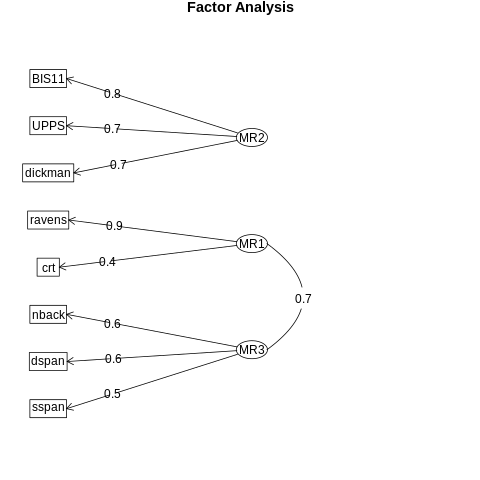

In [25]:
%%R -i imp_efa_df

library(tidyverse)
library(psych)
imp_efa_df <- imp_efa_df %>%
   rename(UPPS = upps_impulsivity_survey.lack_of_premeditation,
         nback = adaptive_n_back.mean_load,
         BIS11 = bis11_survey.Nonplanning,
         dickman = dickman_survey.dysfunctional,
         dspan = digit_span.reverse_span,
         sspan = spatial_span.reverse_span,
         crt = cognitive_reflection_survey.correct_proportion,
         ravens = ravens.score
         )

BIC_df <- data.frame(nfactors = seq(1, 4), SABIC=NA)

for (i in 1:nrow(BIC_df)){
  fa_result <- fa(imp_efa_df, nfactors=BIC_df$nfactors[i])
  BIC_df$SABIC[i] = fa_result$SABIC
}

fa_result <- fa(imp_efa_df, nfactors=3)

fa.diagram(fa_result)